# **The Stokes equations - adaptive mesh refinement**
**Joel Kronborg**

# **Abstract**

This short report shows an example of how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

Stokes flow past a cylinder in a square domain was simulated. The mesh was locally refined using error approximation with an adjoint solution. Tests were run with the cylinder placed at different positions and with different weights for the adjoint solution. Finally an iterative mesh refinement algorithm was implemented. In general the errors were large close to the cylinder, and in several cases it was also large close to some of the boundaries, which caused the mesh to refine in those areas. 

I did this lab in collaboration with Frida Svelander.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**The domain**

The domain size was set to $L=H=4$, and $\psi_1=(0,0)$, $\psi_2=0$, $\psi_3=(1,0)$, which corresponds to weight on the drag force. The postion of the cylinder was then varied to see the effects on where the mesh was refined. In the code in the results section, three positions are shown: $(2,2)$, $(3.5,3.5)$ and $(0.5,0.5)$. This shows effects when the cylinder is placed in the center of the domain, as well as close to the different boundaries. 

**The functional**

The cylinder was placed in the center of the domain, i.e. at $(2,2)$. Simulations were run with five different settings on $\psi$ corresponding to weights on flow velocity in the $x$ and $y$ directions, pressure, and drag and lift force respectively.

**Adaptive mesh refinement**

Finally a method for iteratively refining the mesh was implemented. To get more difference between the refined and unrefined mesh elements, the original mesh for the adaptive mesh refinement was here generated with a resolution of $8$. The tolerance was set to $10^{-3}$, and refinement continued until the error was lower than the tolerance. $\psi_3=(1,0)$, i.e. weight on the drag force error was used to evaluate the error.

**Define domain and mesh**

To make running tests with different settings easier, i changed each cell in the template to a separate function with arguments and return variables.

In [3]:
def original_meshing(res=32, xc=2, yc=2, rc=0.2, plot_result=True):
  # Define rectangular domain 
  L = 4
  H = 4

  # Define circle
#  xc = 0.5*L
#  yc = 0.5*H
#  rc = 0.2

  # Generate mesh (examples with and without a hole in the mesh) 
  resolution = res
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

  # Local mesh refinement (specified by a cell marker)
  init_no_levels = 0
  for i in range(0,init_no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(0.5, 0.5)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  if plot_result:
    plt.figure()
    plot(mesh)
    plt.show()

  return mesh, L, H

**Define finite element approximation spaces**

In [4]:
def approx_spaces(mesh):
  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

  return V, W, Q, u, v, w, p, q, phi, theta, va, wa, qa

**Define boundary conditions**

In [5]:
def boundary_conditions(V, Q, L, H):
  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  return uin, ib, wb, bb

# **Results**

**Define and solve variational problems**

In [6]:
def variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi1_x="0.0", psi1_y="0.0", psi2_p="0.0", psi3_x="0.0", psi3_y="0.0"):
  # Set boundary penalty parameter gamma 
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe functional that defines the adjoint problem
  #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
  #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
  psi1 = Expression((psi1_x,psi1_y), element = V.ufl_element()) # Velocity in x and y
  psi2 = Expression(psi2_p, element = Q.ufl_element())          # Pressure
  psi3 = Expression((psi3_x,psi3_y), element = V.ufl_element()) # Drag and lift force

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system 
  solve(res == 0, w)

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - psi3, va))*ds 
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system 
  solve(res_a == 0, wa) 

  return f, gamma

**Visualize solution and export files**

A plot of the residual was added. It's not exactly the expression that is used to evaluate the error, but still gives some visual idea of where the residual is large. These areas are of particular interest, since they lead to large errors if the adjoint solution is large there as well.

In [7]:
def plotting(u, p, phi, theta, V, Q):
  !rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")
  file_phi = File("results-Stokes/phi.pvd")
  file_theta = File("results-Etokes/theta.pvd")

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn

  # Plot solution
  plt.figure()
  plot(u_fcn, title="Velocity")

  plt.figure()
  plot(p_fcn, title="Pressure")

  plt.figure()
  plot(phi_fcn, title="Adjoint velocity")

  plt.figure()
  plot(theta_fcn, title="Adjoint pressure")

  plt.figure()
  res = grad(p) - div(grad(u))
  plot(project(sqrt(dot(res,res)+div(u)*div(u)), Q), title="Residual")
          
  plt.show()

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

**Compute error indicators**

In [8]:
def mesh_refinement(W, f, gamma, u, p, phi, theta, ib, wb, bb, mesh, plot_result=True):
  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)

  # Compute local error indicators over the cells of the mesh 
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()] 
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)

  if plot_result:
    plt.figure(figsize=(16,16))
    plot(mesh)
    plt.show()

  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)
  s = 'Total error = ' + repr(tot_err) 
  print(s)

  return mesh, tot_err

**The domain**

To run tests with different positions for the cylinder, comment/uncomment the top three rows, or change the position arguments to original_meshing.

Placing the cylinder in the center $(2,2)$ gives a large adjoint velocity and greatly varying adjoint pressure close to the cylinder. This is also where most of the mesh refinement happens, but it is also refined close to the upper and lower boundaries in the center of the domain.

With the cylinder in the upper right corner $(3.5, 3.5)$, the adjoint velocity is still largest close to the cylinder, but the residual is larger on the lower half of the cylinder boundary, and in the lower right corner of the domain. This gives a lot of refinement below the cylinder and in the lower right corner, but there is also refinement along the right half of the upper boundary.

Finally, with the cylinder in the lower left corner $(0.5,0.5)$ the adjoint velocity is still largest close to the cylinder, and the adjoint pressure is large in the lower left corner of the domain. The residual is large along the boundary of the cylinder, and this is also where the mesh gets refined.

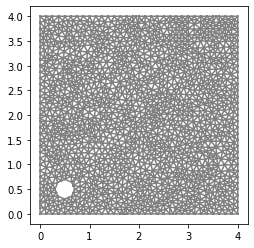

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just

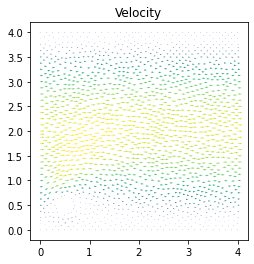

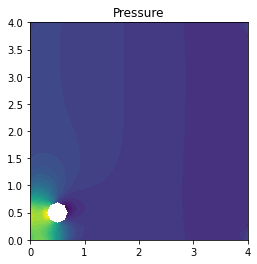

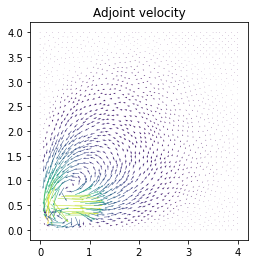

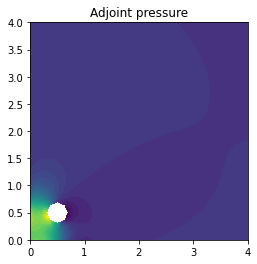

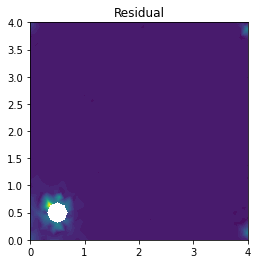

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


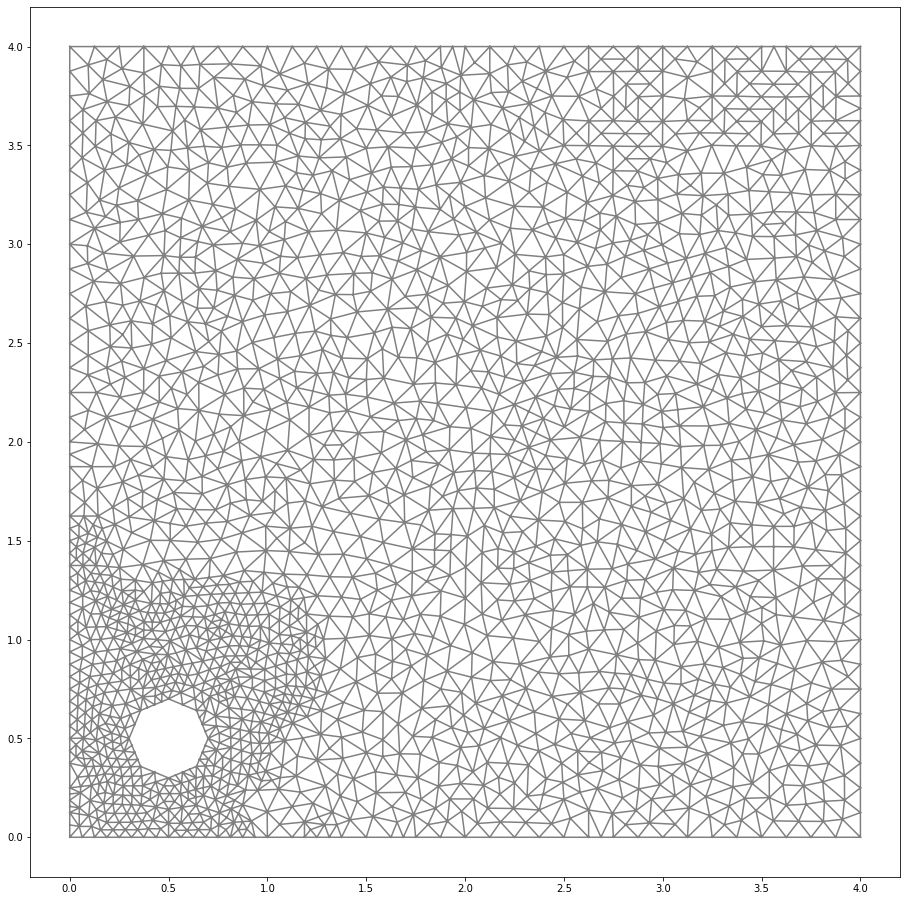

Calling FFC just-in-time (JIT) compiler, this may take some time.
Total error = 0.025095081087109405


In [9]:
#mesh, L, H = original_meshing(32, 2, 2)
#mesh, L, H = original_meshing(32, 3.5, 3.5)
mesh, L, H = original_meshing(32, 0.5, 0.5)
V, W, Q, u, v, w, p, q, phi, theta, va, wa, qa = approx_spaces(mesh)
uin, ib, wb, bb = boundary_conditions(V, Q, L, H)
f, gamma = variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi3_x="1.0")
plotting(u, p, phi, theta, V, Q)
mesh, tot_err = mesh_refinement(W, f, gamma, u, p, phi, theta, ib, wb, bb, mesh, True)

**The functional**

To run tests with different $\psi$, comment/uncomment the calls to variational_prob, or change the psi argument. The default arguments for $\psi$ are $0$.

The drag force $(\psi_3=(1,0))$ gives a large adjoint velocity and greatly varying adjoint pressure close to the cylinder. This is also where most of the mesh refinement happens, but it is also refined close to the upper and lower boundaries in the center of the domain.

The lift force $(\psi_3=(0,1))$ gives a similar refinement, but close to the upper and lower boundaries the refinement is further right, i.e. downstream from the cylinder. The adjoint velocity also shows generally larger velocities in the right half of the domain. The adjoint pressure again shows largest variations close to the cylinder, with high pressure below and low pressure above it.

The velocity in the x-direction $(\psi_1=(1,0))$ gives large adjoint velocities in the right half of the domain, but low close to the upper and lower boundaries and close to the cylinder. The adjoint pressure looks to be decreasing linearly from left to right, ignoring the cylinder. The mesh is refined mainly in the proximity of the cylinder.

In the y-direction $(\psi_1=(0,1))$ the adjoint velocity is largest close to the right boundary, and the pressure decreases from the bottom to the top. The mesh is refined around the cylinder, but also more in the wake to the right of the cylinder than when x-velocities were considered. There is also refinement along the upper and lower boundaries, mostly in the right half of the domain.

For the pressure $(\psi_1=(0,1))$ the adjoint velocity is large in the right half plane, but the adjoint pressure is larger in the left half plane. The mesh is refined in the left half of the domain, as well as around the cylinder and the right corners.

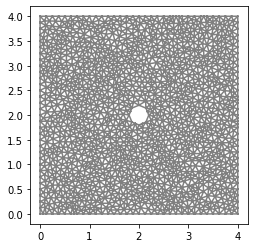

rm: cannot remove 'results-NS/*': No such file or directory


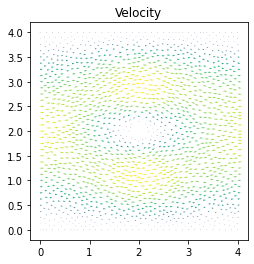

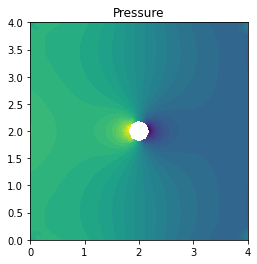

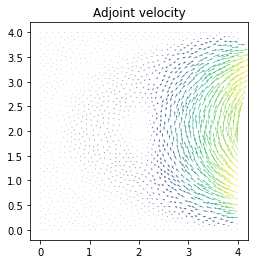

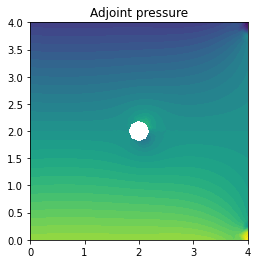

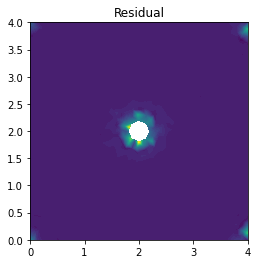

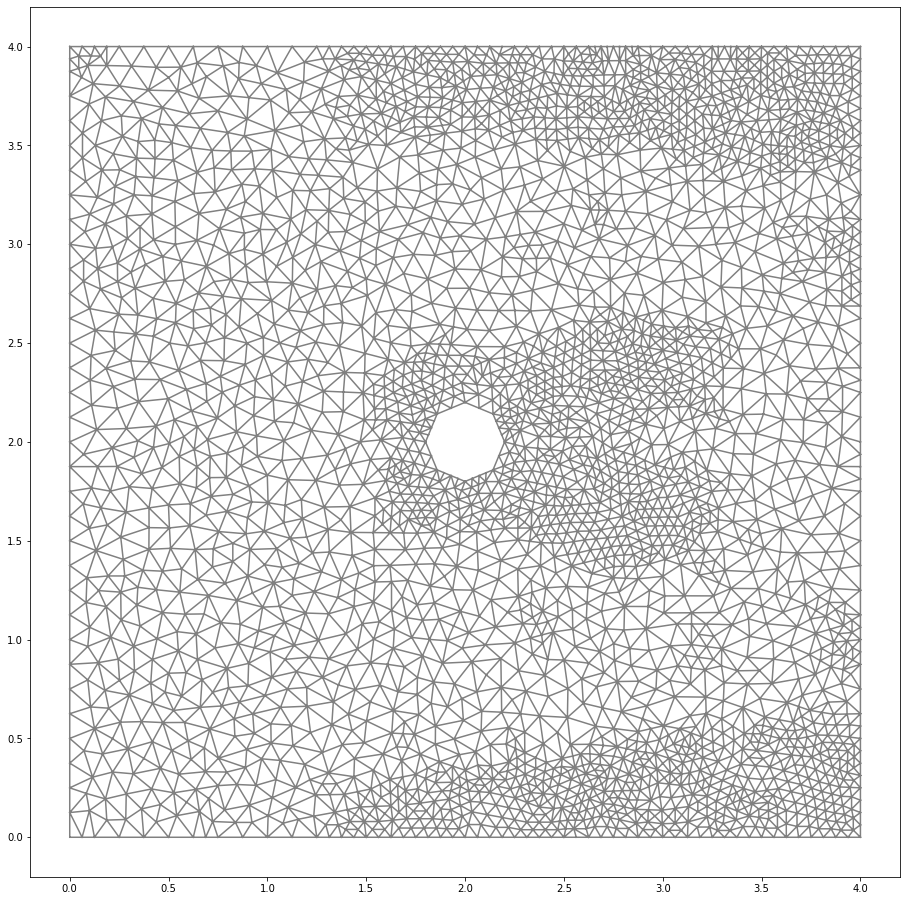

Total error = -6.516202379578462e-05


In [10]:
mesh, L, H = original_meshing(32)
V, W, Q, u, v, w, p, q, phi, theta, va, wa, qa = approx_spaces(mesh)
uin, ib, wb, bb = boundary_conditions(V, Q, L, H)
#f, gamma = variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi3_x="1.0")
#f, gamma = variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi3_y="1.0")
#f, gamma = variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi1_x="1.0")
f, gamma = variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi1_y="1.0")
#f, gamma = variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi2_p="1.0")
plotting(u, p, phi, theta, V, Q)
mesh, tot_err = mesh_refinement(W, f, gamma, u, p, phi, theta, ib, wb, bb, mesh, True)

**Adaptive mesh refinement**

With these settings the refinement algorithm converged in 5 iterations. Most of the refinement happened in areas close to the cylinder and near the upper and lower boundaries centered in the x-direction.

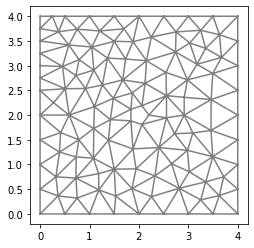

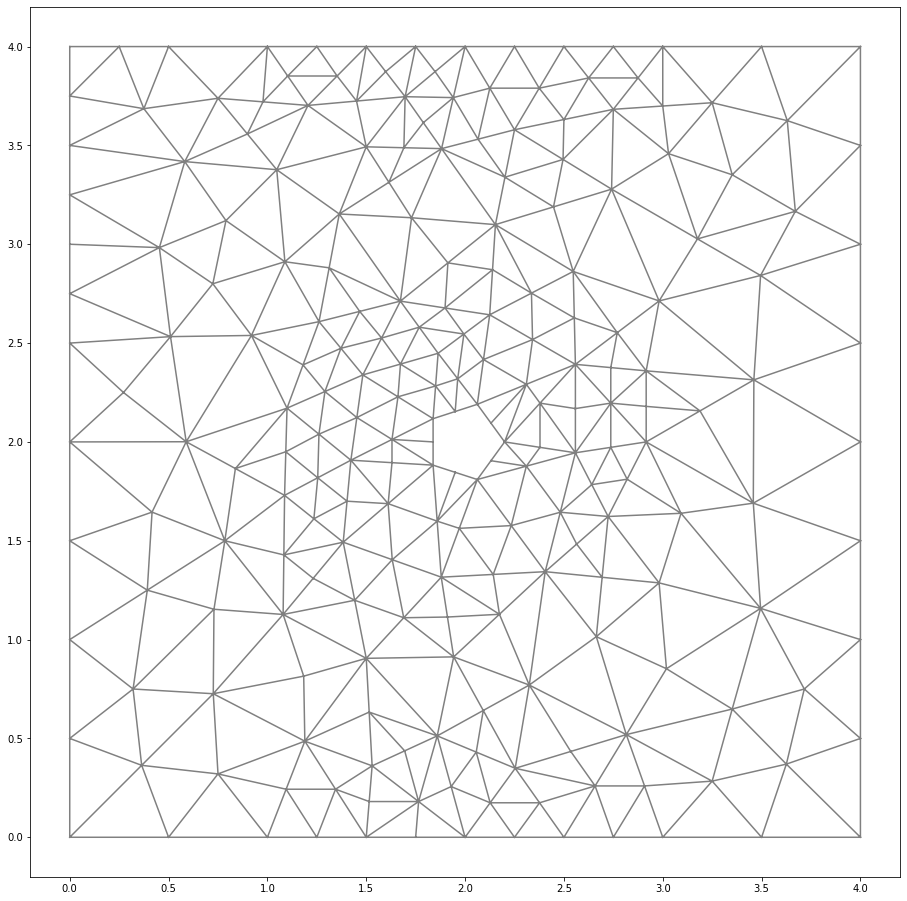

Total error = 0.016464737355588906


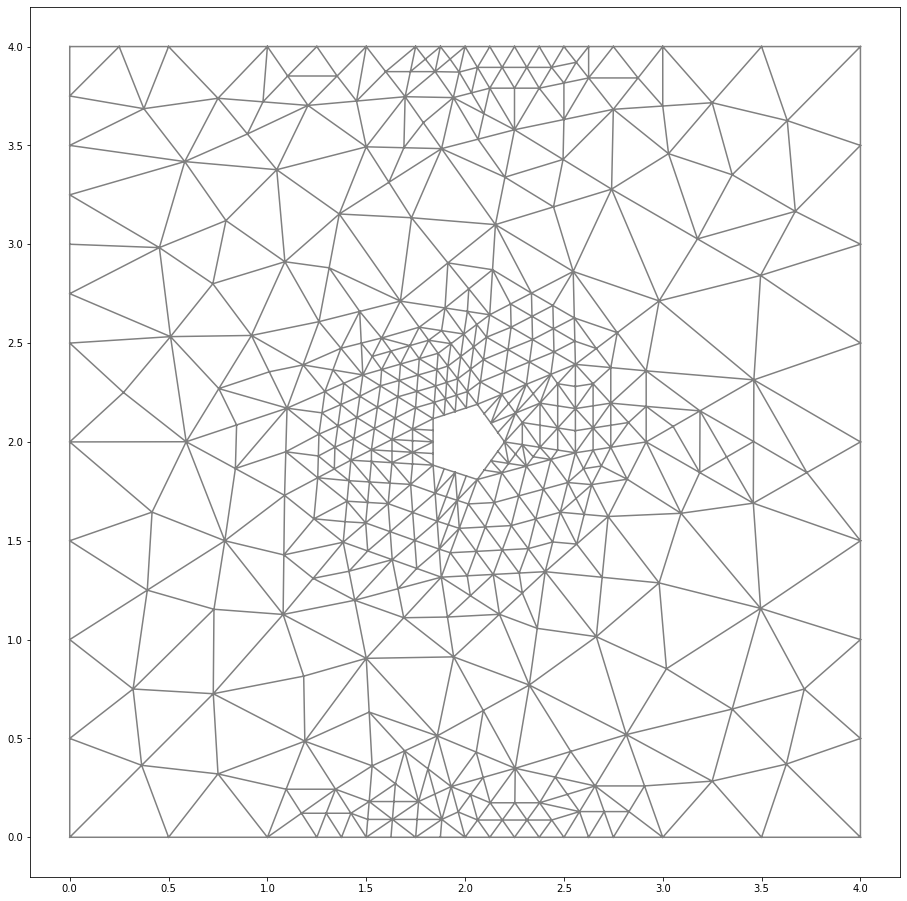

Total error = 0.021531854870168884


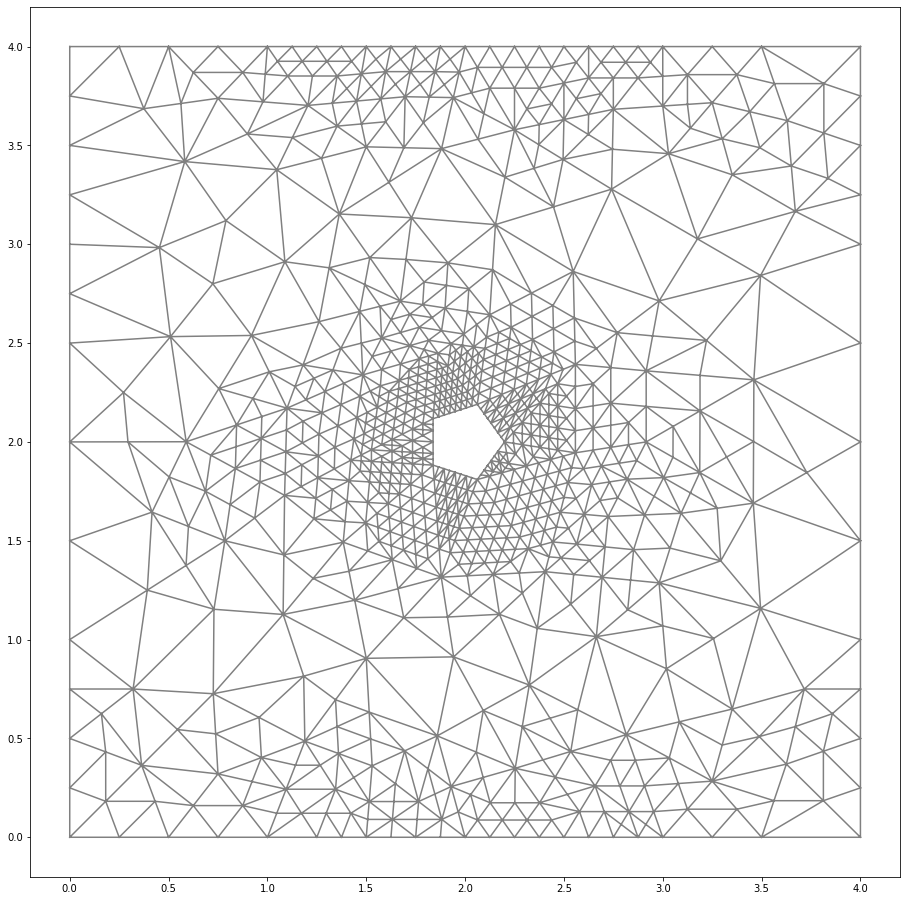

Total error = 0.003957365055154879


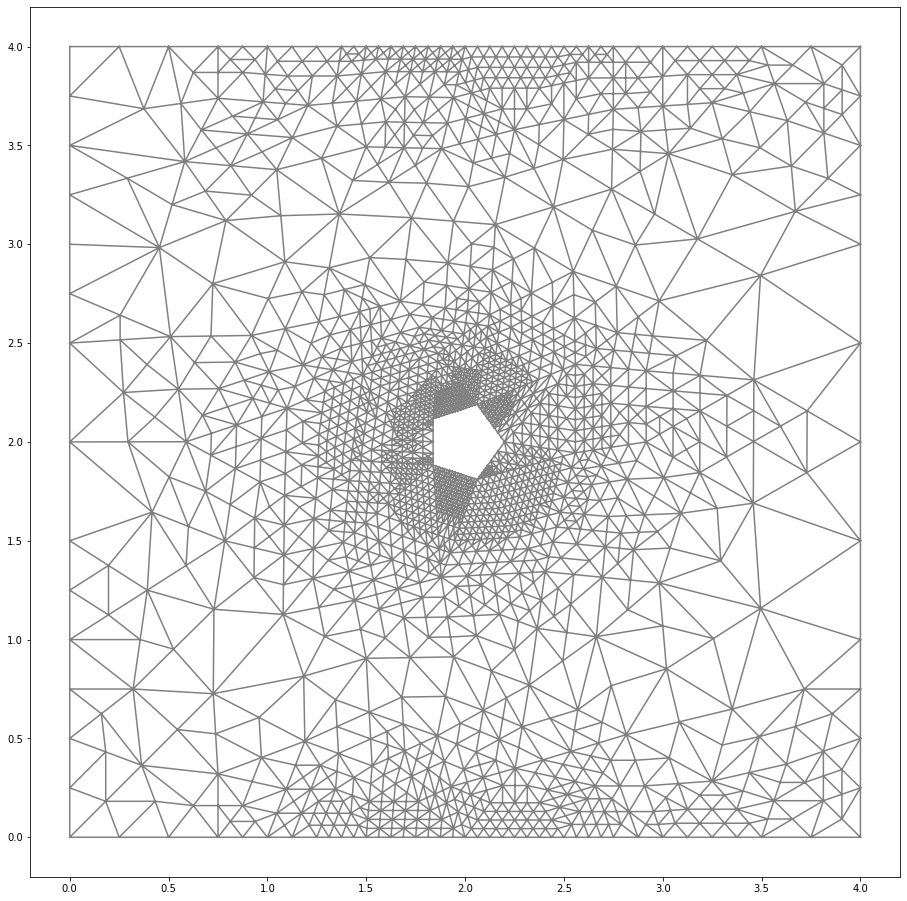

Total error = 0.0012676763625442677


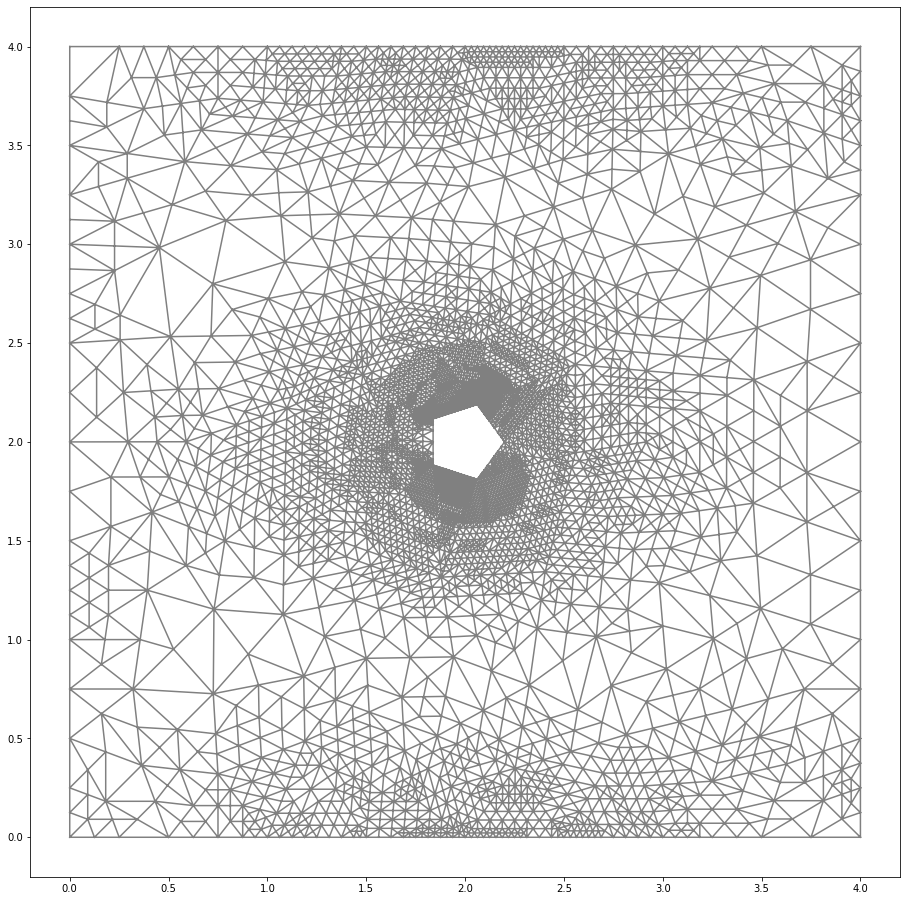

Total error = 0.0002939823170829553


In [11]:
mesh, L, H = original_meshing(8)
tot_err = 1e10
tol = 1e-3
while abs(tot_err) > tol:
  V, W, Q, u, v, w, p, q, phi, theta, va, wa, qa = approx_spaces(mesh)
  uin, ib, wb, bb = boundary_conditions(V, Q, L, H)
  f, gamma = variational_prob(V, Q, u, v, w, p, q, phi, theta, va, wa, qa, uin, ib, wb, bb, mesh, psi3_x="1.0")
#  plotting(u, p, phi, theta, V, Q)
  mesh, tot_err = mesh_refinement(W, f, gamma, u, p, phi, theta, ib, wb, bb, mesh, True)

# **Discussion**

An adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

**The domain**

Since $\psi_3=(1,0)$ we can expect errors in areas where the drag force is significant, so it's no surprise that this is in the vicinity of the cylinder regardless of the position of it. However, reasons for the refinement along the upper and lower boundaries are not as obvious. Visually, the residual is not as large as it is near the cylinder, and the adjoint velocity is also large mainly closer to the cylinder. At the right corners the residual is also large, which probably contributes to this effect. It's not obvious why it is large there though, it may have to do with the boundary conditions.

**The functional**

It's interesting to note that putting the weight on the pressure gives generally more refinement in the left half plane than the right, which implies that there are significant errors in the pressure there. They may of course be larger in magnitude in other areas, but to get some idea of the magnitude I ran the adaptive algorithm with $\psi_2=1$ (by changing the last argument to psi2_p=1 in the code cell above). This gave mostly refinement close to the cylinder, but also a lot in the left half of the domain, and the right corners as well.

Most other $\psi$ gave more refinement in the right half of the domain, which makes sense since the flow is likely affected more by the cylinder in its wake. $\psi_1=(1,0)$ gave mostly refinement only centered around the cylinder, which implies that the error for the horizontal velocity is small in the wake of the cylinder, which is nice.

**Adaptive mesh refinement**

With the settings for the adaptive mesh refinement that were used here the algorithm works fairly well. It is however a bit surprising that the total error grows in the second iteration, since a finer mesh should intuitively give a more exact solution. With other settings similar effects can occur. For some settings, e.g. starting resolution of 16, the script crashes before converging since some elements get too small. Starting with 8 and 32 works fine, but yields quite different results. Part of the reason may be that the shape of the cylinder is different, with the coarser mesh it's just a pentagon. But there's probably more to it, so when working with mesh refinement it's something to keep in mind that the end result may depend on more than just the tolerance and problem formulation.